In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

import joblib
import warnings
warnings.filterwarnings("ignore")


In [5]:
df = pd.read_csv("Datasets/healthcare-dataset-stroke-data.csv")

In [6]:
df= df.drop(["id"],axis=1 , )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [9]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


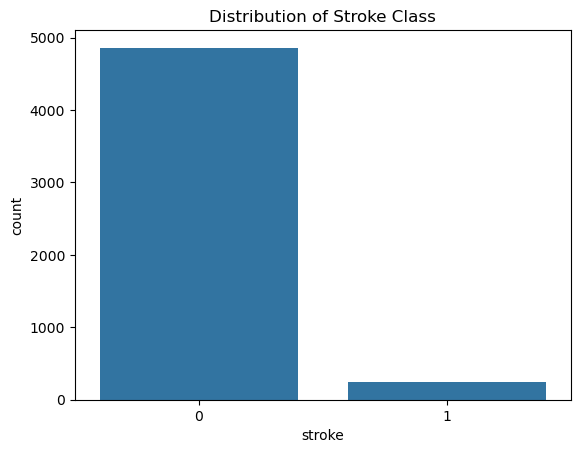

In [11]:
plt.figure()
sns.countplot(x="stroke",data=df)
plt.title("Distribution of Stroke Class")
plt.show()

In [13]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [25]:
#Missing Values 

Dt_bmi_pipe = Pipeline(steps =[
    ("scale",StandardScaler()),
    ("dtr",DecisionTreeRegressor())
])

X=df[["gender","age","bmi"]].copy()

#male 0 , female 1 ,other -1 
X.gender = X.gender.replace({"Male":0, "Female":1, "Other":-1}).astype(np.uint8)

#missing bmi
missing = X[X.bmi.isna()]
X = X.dropna(subset=['bmi'])  
y = X.pop("bmi")  

Dt_bmi_pipe.fit(X, y)

#guess missing bmi values using gender and age
predicted_bmi = pd.Series(Dt_bmi_pipe.predict(missing[["gender", "age"]]), index=missing.index)

df.loc[missing.index, "bmi"] = predicted_bmi


In [28]:
df["gender"]= df["gender"].replace({"Male":0, "Female":1, "Other":-1}).astype(np.uint8)
df["Residence_type"]= df["Residence_type"].replace({"Rural":0, "Urban":1}).astype(np.uint8)
df["work_type"]= df["work_type"].replace({"Private":0, "Self-employed":1, "Govt_job":2,"children":-1,"Never_worked":-2}).astype(np.uint8)

X= df[["gender","age","hypertension","heart_disease","work_type","avg_glucose_level","bmi"]]
y=df["stroke"]

X_train,X_test,y_train,y_test = train_test_split(X,y , test_size=0.1 ,random_state=42 )

loggreg_pipe = Pipeline(steps=[("scale",StandardScaler()),("LR",LogisticRegression())])

loggreg_pipe.fit(X_train,y_train)

y_pred = loggreg_pipe.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Cm: \n",confusion_matrix(y_test, y_pred))
print("Classification Report: \n",classification_report(y_test, y_pred))


Accuracy: 0.9452054794520548
Cm: 
 [[483   0]
 [ 28   0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       483
           1       0.00      0.00      0.00        28

    accuracy                           0.95       511
   macro avg       0.47      0.50      0.49       511
weighted avg       0.89      0.95      0.92       511



In [37]:
joblib.dump(loggreg_pipe,"log_reg.pkl")
loaded_log_reg_pipe = joblib.load ("log_reg.pkl")

new_patient = pd.DataFrame({
    "gender":[0],
    "age":[36],
    "hypertension":[1],
    "heart_disease":[0],
    "work_type":[0],
    "avg_glucose_level":[70],
    "bmi":[23]
})

new_patient_result = loaded_log_reg_pipe.predict(new_patient)
new_patient_result_prob = loaded_log_reg_pipe.predict_proba(new_patient)

In [39]:
print("New patient class:",new_patient_result)
print("New patient disease probability:",new_patient_result_prob)

New patient class: [0]
New patient disease probability: [[0.98805351 0.01194649]]
